In [1]:
# pylint: disable=line-too-long
# pylint: disable=wrong-import-order
# pylint: disable=wrong-import-position
# pylint: disable=pointless-string-statement
# pylint: disable=pointless-statement
# pylint: disable=invalid-name
# pylint: disable=duplicate-code
# pylint: disable=missing-function-docstring

In [2]:
%matplotlib inline
import numpy as np

In [3]:
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.analysis import base_analysis as ba
from quantify_core.analysis import cosine_analysis as ca
from quantify_core.data.handling import set_datadir
from quantify_core.measurement import MeasurementControl
from quantify_core.utilities.examples_support import (
    default_datadir,
    mk_cosine_instrument,
)
from quantify_core.utilities.experiment_helpers import create_plotmon_from_historical

In [4]:
from quantify_core.utilities.inspect_utils import display_source_code
from quantify_core.visualization.instrument_monitor import InstrumentMonitor



In [5]:
# We recommend to always set the directory at the start of the python kernel
# and stick to a single common data directory for all
# notebooks/experiments within your measurement setup/PC
# This sets a default data directory for tutorial purposes. Change it to your
# desired data directory.

In [6]:
set_datadir(default_datadir())  # change me!

Data will be saved in:
/home/slavoutich/quantify-data


In [7]:
meas_ctrl = MeasurementControl("meas_ctrl")

# Create the live plotting intrument which handles the graphical interface
# Two windows will be created, the main will feature 1D plots and any 2D plots will go to the secondary
plotmon = pqm.PlotMonitor_pyqt("plotmon")
# Connect the live plotting monitor to the measurement control
meas_ctrl.instr_plotmon(plotmon.name)

# The instrument monitor will give an overview of all parameters of all instruments
insmon = InstrumentMonitor("Instruments Monitor")

In [8]:
# We create an instrument to contain all the parameters of our model to ensure
# we have proper data logging.
display_source_code(mk_cosine_instrument)

def mk_cosine_instrument() -> Instrument:
    """A container of parameters (mock instrument) providing a cosine model."""

    instr = Instrument("ParameterHolder")

    # ManualParameter's is a handy class that preserves the QCoDeS' Parameter
    # structure without necessarily having a connection to the physical world
    instr.add_parameter(
        "amp",
        initial_value=0.5,
        unit="V",
        label="Amplitude",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "freq",
        initial_value=1,
        unit="Hz",
        label="Frequency",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "t", initial_value=1, unit="s", label="Time", parameter_class=ManualParameter
    )
    instr.add_parameter(
        "phi",
        initial_value=0,
        unit="Rad",
        label="Phase",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "noise_level",
        initial_value=0.05,
        unit="V",
        label="Noise level",
        parameter_class=ManualParameter,
    )
    instr.add_parameter(
        "acq_delay", initial_value=0.02, unit="s", parameter_class=ManualParameter
    )

    def cosine_model():
        sleep(instr.acq_delay())  # simulates the acquisition delay of an instrument
        return (
            cos_func(instr.t(), instr.freq(), instr.amp(), phase=instr.phi(), offset=0)
            + np.random.randn() * instr.noise_level()
        )

    # Wrap our function in a Parameter to be able to associate metadata to it, e.g. unit
    instr.add_parameter(
        name="sig", label="Signal level", unit="V", get_cmd=cosine_model
    )

    return instr

In [9]:
pars = mk_cosine_instrument()

In [10]:
# by setting this to a non-zero value we can see the live plotting in action for a slower experiment
pars.acq_delay(0.0)

In [11]:
meas_ctrl.settables(
    pars.t
)  # as a QCoDeS parameter, 't' obeys the JSON schema for a valid Settable and can be passed to the meas_ctrl directly.
meas_ctrl.setpoints(np.linspace(0, 2, 50))
meas_ctrl.gettables(
    pars.sig
)  # as a QCoDeS parameter, 'sig' obeys the JSON schema for a valid Gettable and can be passed to the meas_ctrl directly.
dataset = meas_ctrl.run("Cosine test")

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

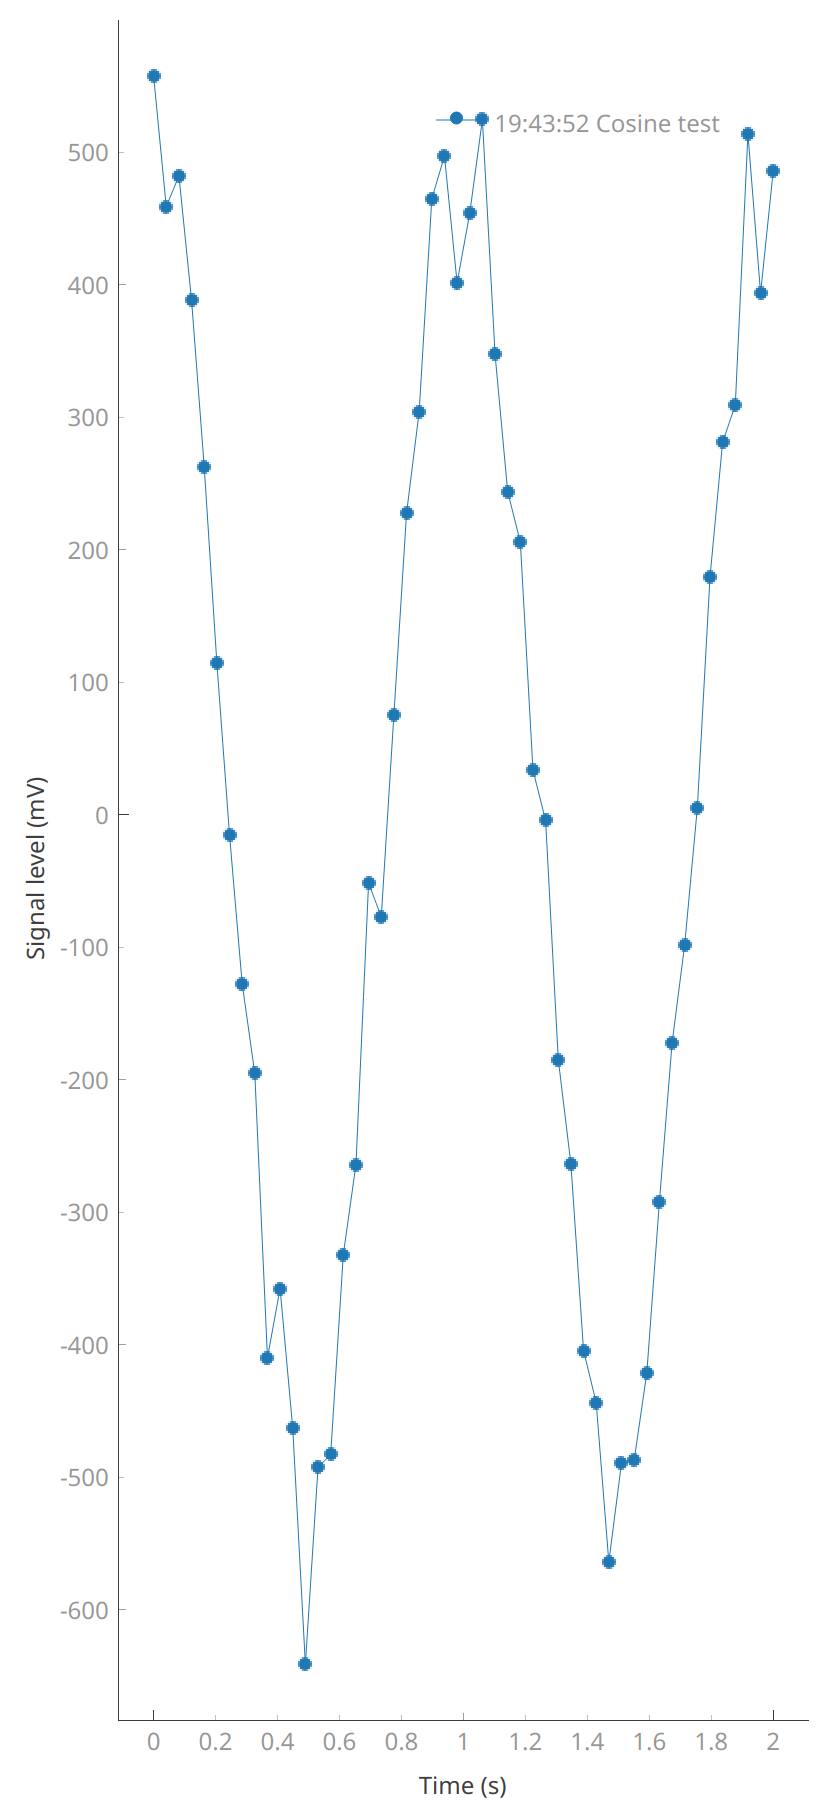

In [12]:
plotmon.main_QtPlot

In [13]:
# The dataset has a time-based unique identifier automatically assigned to it
# The name of the experiment is stored as well
dataset.attrs["tuid"], dataset.attrs["name"]

('20230926-194352-284-32d737', 'Cosine test')

In [14]:
dataset

<xarray.Dataset>
Dimensions:  (dim_0: 50)
Coordinates:
    x0       (dim_0) float64 0.0 0.04082 0.08163 0.1224 ... 1.918 1.959 2.0
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.5576 0.459 0.4823 0.3882 ... 0.5139 0.3937 0.4862
Attributes:
    tuid:                             20230926-194352-284-32d737
    name:                             Cosine test
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [15]:
# By default the meas_ctrl updates the datafile and live plot every 0.1 seconds (and not faster) to reduce overhead.
meas_ctrl.update_interval(
    0.1
)  # Setting it even to 0.01 creates a dramatic slowdown, try it out!



In [16]:
meas_ctrl.settables(pars.t)
meas_ctrl.setpoints(np.linspace(0, 50, 1000))
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("Many points live plot test")

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

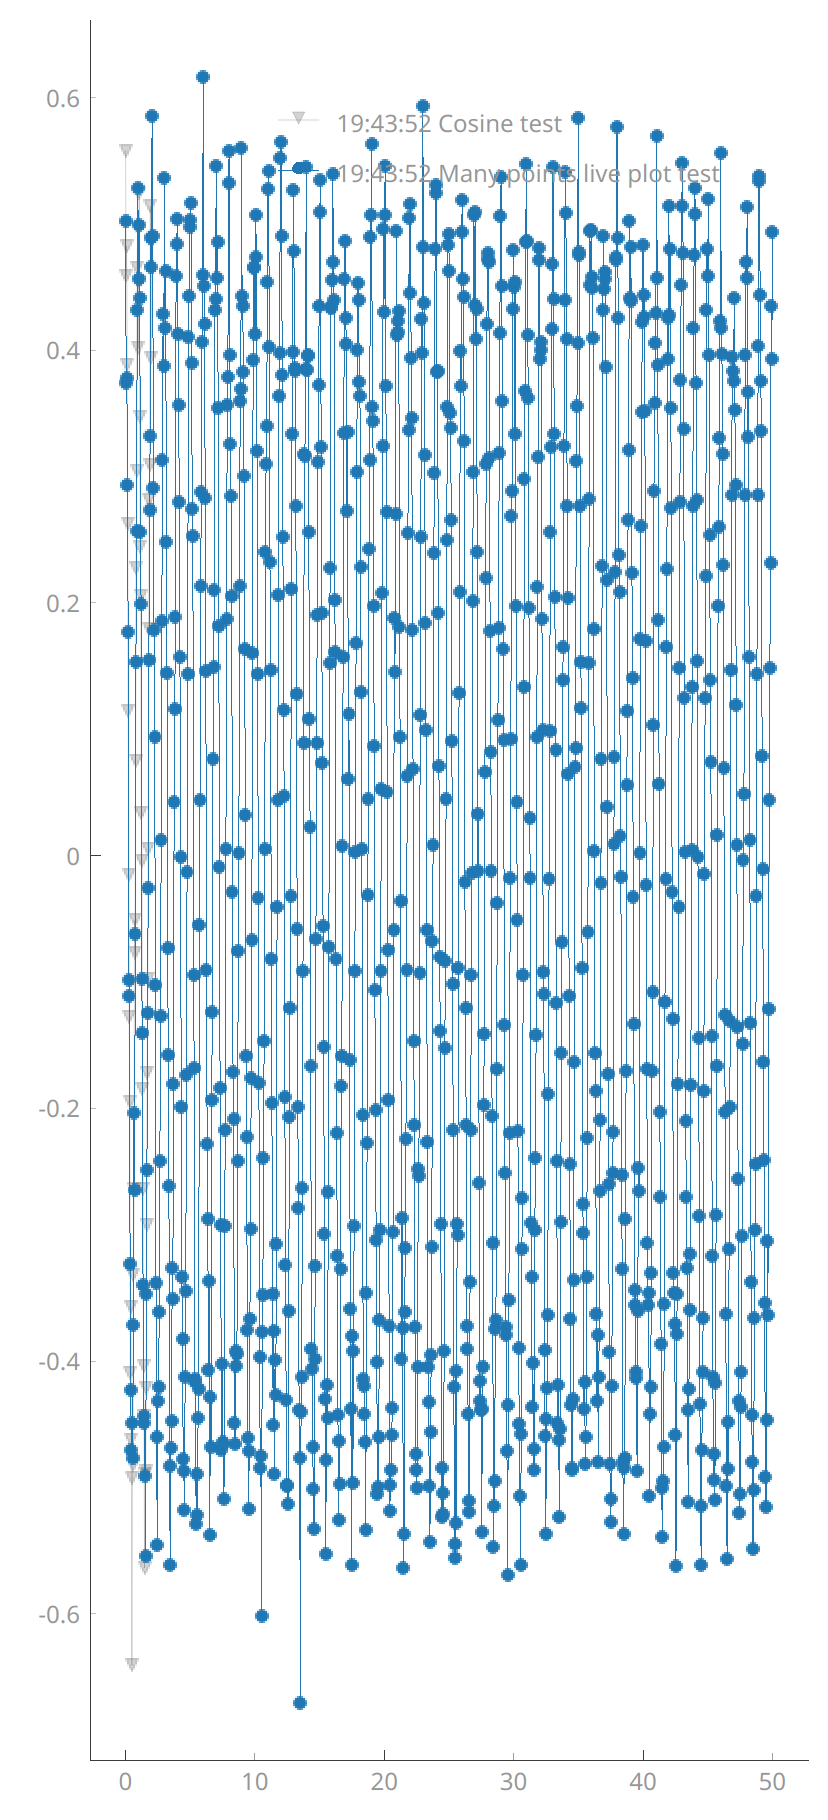

In [17]:
plotmon.main_QtPlot

In [18]:
pars.noise_level(0)  # let's disable noise from here on to get prettier figures

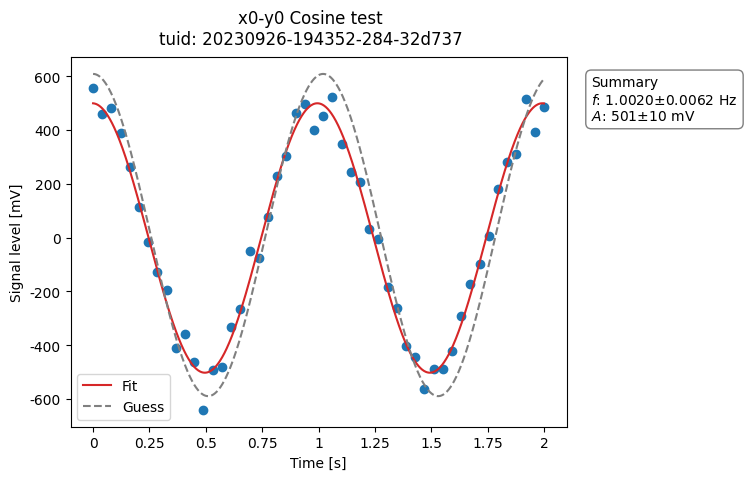

In [19]:
a_obj = ca.CosineAnalysis(label="Cosine test").run()
a_obj.display_figs_mpl()

In [20]:
pars.acq_delay(0.0001)
meas_ctrl.update_interval(2.0)

In [21]:
times = np.linspace(0, 5, 500)
amps = np.linspace(-1, 1, 31)

meas_ctrl.settables([pars.t, pars.amp])
# meas_ctrl takes care of creating a meshgrid
meas_ctrl.setpoints_grid([times, amps])
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("2D Cosine test")

Starting iterative measurement...


 16% completed | elapsed time:      0s | time left:      3s  

 79% completed | elapsed time:      2s | time left:      0s  

100% completed | elapsed time:      3s | time left:      0s  
100% completed | elapsed time:      3s | time left:      0s  

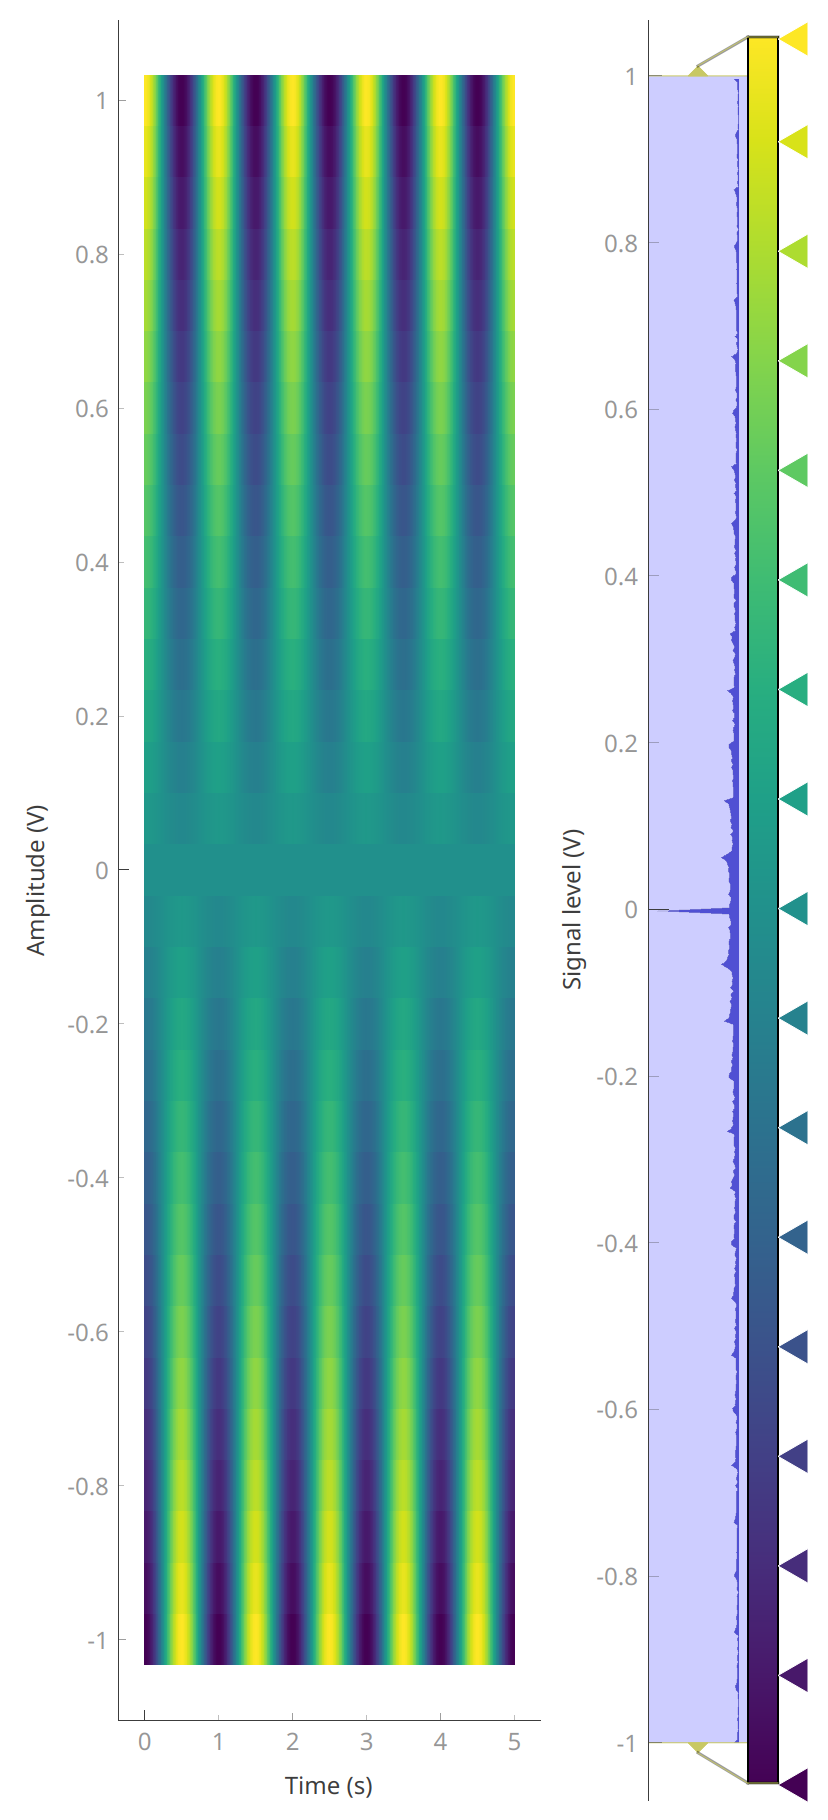

In [22]:
plotmon.secondary_QtPlot

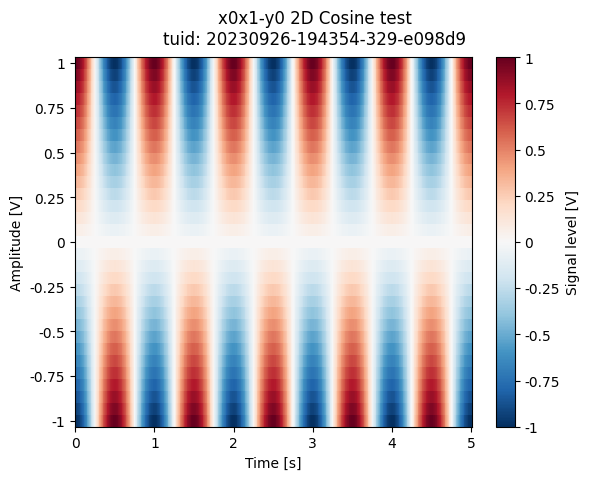

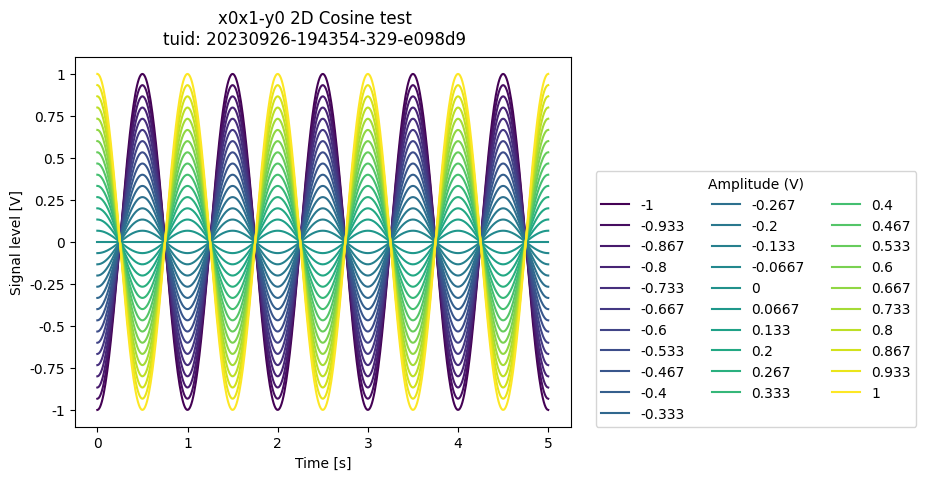

In [23]:
a_obj = ba.Basic2DAnalysis(label="2D Cosine test").run()
a_obj.display_figs_mpl()

In [24]:
r = np.linspace(0, 1.2, 200)
dt = np.linspace(0, 0.5, 200)
f = 3
theta = np.cos(2 * np.pi * f * dt)


def polar_coords(r_, theta_):
    x_ = r_ * np.cos(2 * np.pi * theta_)
    y_ = r_ * np.sin(2 * np.pi * theta_)
    return x_, y_


x, y = polar_coords(r, theta)
setpoints = np.column_stack([x, y])
setpoints[:5]  # show a few points

array([[ 0.00000000e+00, -0.00000000e+00],
       [ 6.03000109e-03, -4.24843885e-05],
       [ 1.20555181e-02, -3.39642455e-04],
       [ 1.80542054e-02, -1.14460856e-03],
       [ 2.39683681e-02, -2.70570137e-03]])

In [25]:
pars.acq_delay(0.0001)
meas_ctrl.update_interval(2.0)

In [26]:
meas_ctrl.settables([pars.t, pars.amp])
meas_ctrl.setpoints(setpoints)
meas_ctrl.gettables(pars.sig)
dataset = meas_ctrl.run("2D radial setpoints")

Starting iterative measurement...
100% completed | elapsed time:      0s | time left:      0s  
100% completed | elapsed time:      0s | time left:      0s  

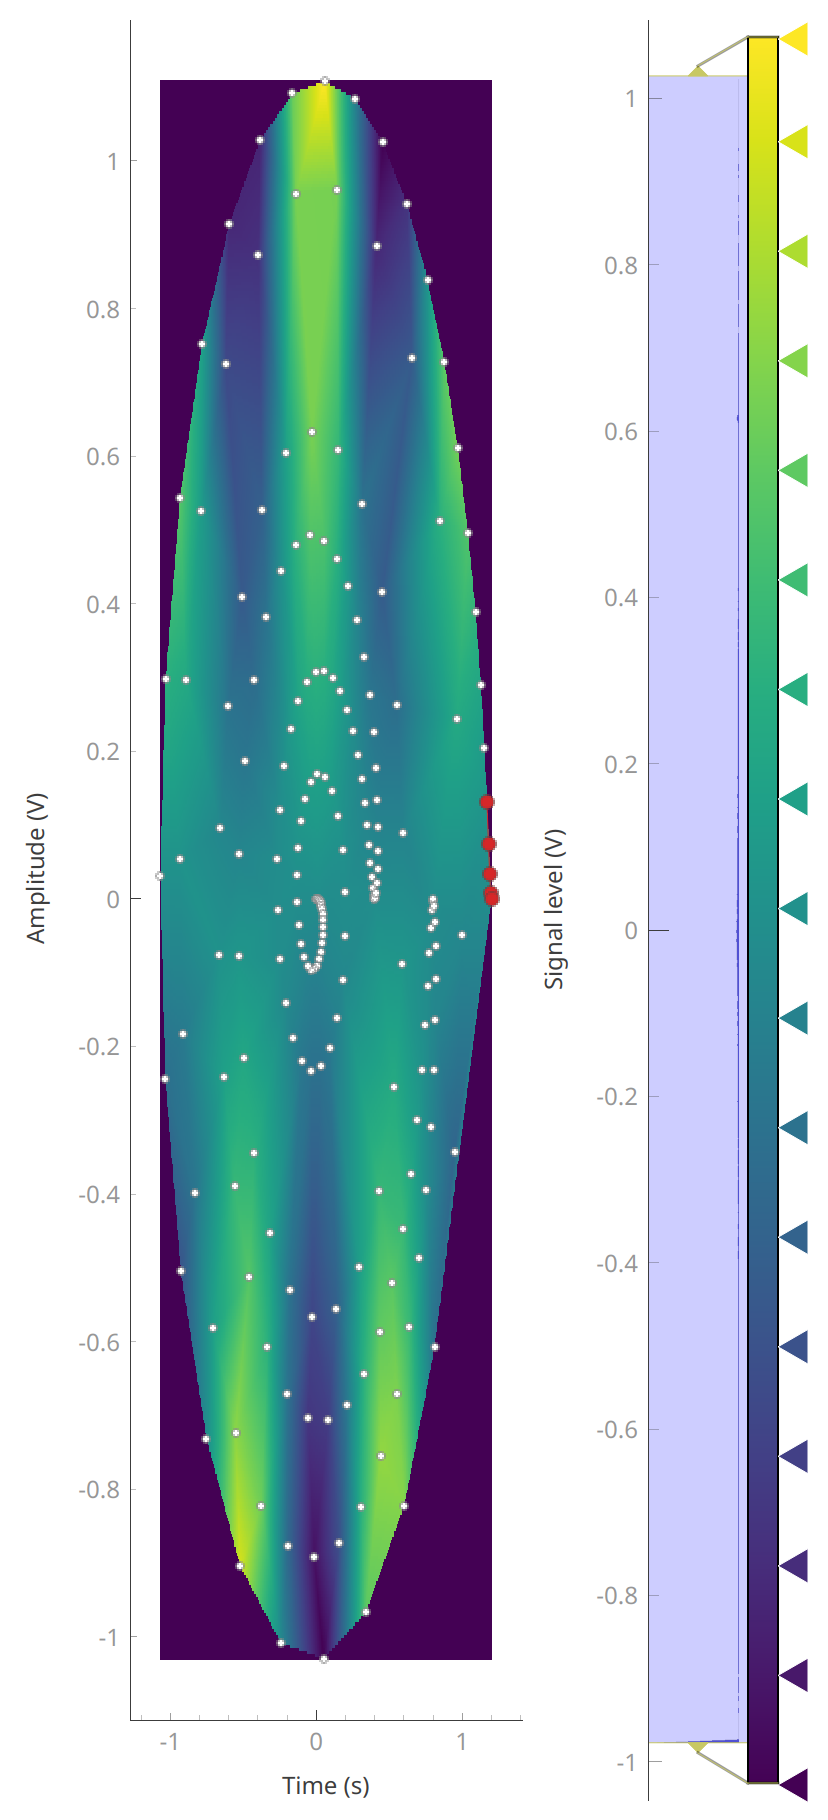

In [27]:
plotmon.secondary_QtPlot

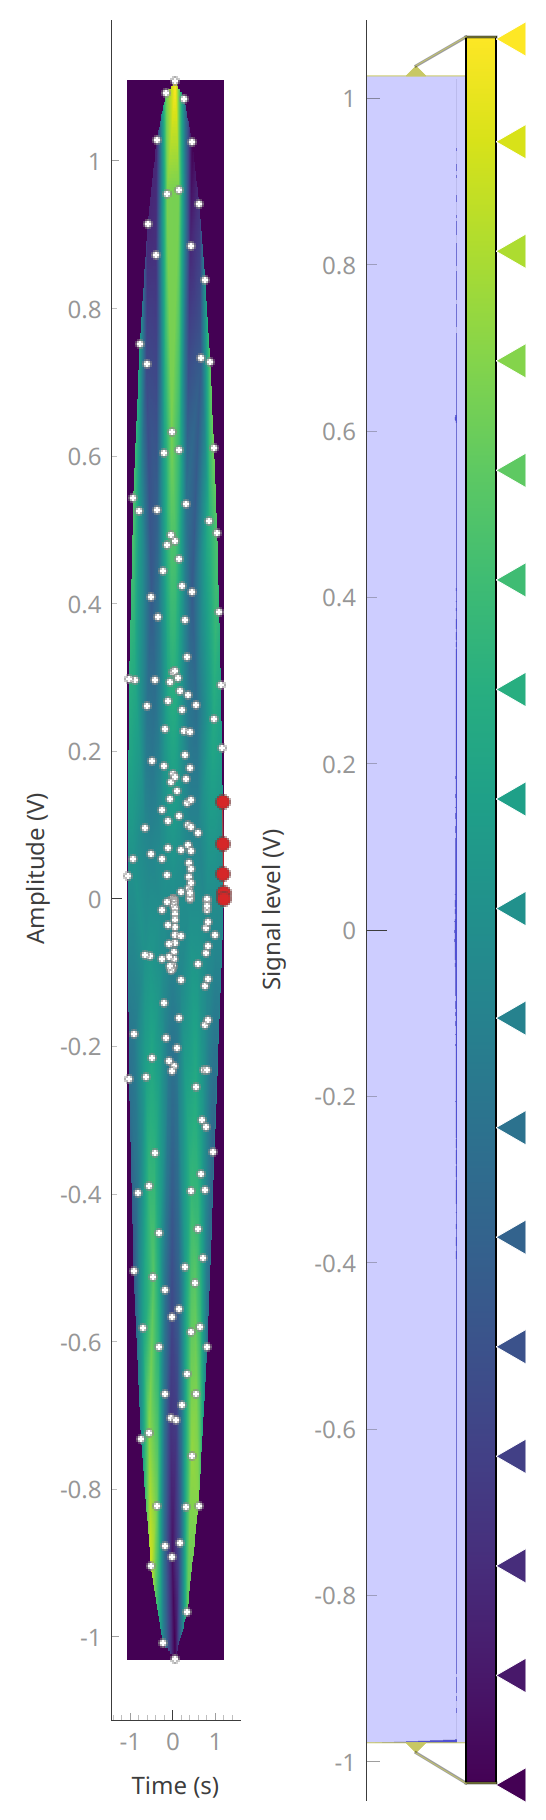

In [28]:
plotmon_loaded = create_plotmon_from_historical(label="2D radial setpoints")
plotmon_loaded.secondary_QtPlot